# Graded Exercise #3_ With DASK

This file deals with the same process in <[Primary] Assignment_Without_DASK.ipynb> but with DASK. All the explanations, except for implementation of DASK and comparison between the results with and without DASK, are in the other file.
DASK is used in this version to:
- Run the machine learning model
- Perform hyperparameter optimization

## 1. Creating the work space and set up DASK
Import all the relevant folders and include the file path to the where the imagery data are. 

In [ ]:
import numpy as np
import pandas as pd
import rasterio
import rasterio.features
import rasterio.warp
import geojson
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
import os
from os.path import isfile, join

In [ ]:
import dask.dataframe as da
from dask.distributed import Client
client = Client(processes=False, threads_per_worker=4,
                n_workers=1, memory_limit='2GB')
partition_size = 5

In [ ]:
directory_path = 'EuroSAT_MS/'

## 2. Creating target variable data frame and relevant features

In [ ]:
# Function to calculate NDVI, NDWI, and SAVI based on band values
def calculate_indices(bands):
    band4 = bands[3]  # Red
    band3 = bands[2]  # Green
    band8 = bands[7]  # NIR

    # Define the formula constants for SAVI
    L = 0.428
    # calculate the indices
    ndvi = (band8 - band4) / (band8 + band4)
    ndwi = (band3 - band8) / (band3 + band8)
    savi = (band8 - band4) / (band8 + band4 + L) * (1.0 + L)
    return ndvi, ndwi, savi

In [ ]:
# Function to read all tiff files into dataframe together with central coordinates and relevant features
def read_data (directory_path):
    # Build a datframe
    data = pd.DataFrame(columns=["Lat", "Lon", "Lulc_class", "mean_val", "range_val", "median_val", "min_val", "max_val", "ndvi", "ndwi", "savi",
                             "band1", "band2", "band3", "band4", "band5", "band6", "band7", "band8", "band9", "band10", "band11", "band12"])
    # Loop through the subfolders
    for subdir in os.listdir(directory_path):
        subfolder_path = os.path.join(directory_path, subdir)
        if os.path.isdir(subfolder_path):
        # Get a list of all TIF files in the subfolder
            tif_files = [file for file in os.listdir(subfolder_path) if file.endswith('.tif')]

            for tif_file in tif_files:
                tif_path = os.path.join(subfolder_path, tif_file)
                # Read the raster file using rasterio
                with rasterio.open(tif_path) as src:
                    # Read and stack all bands into a single array
                    bands = src.read()
                    # Transfer the uint16 to int16
                    bands = bands.astype(np.int16)

                    # Get the center coordinates and  pixel location
                    lon, lat = src.xy(src.width // 2, src.height // 2)
                    row, col = src.index(lon, lat)
                    bands = bands[:, row, col]
                    # Extract LULC class from the subfolder name
                    lulc_class = subdir

                    # Calculate NDVI, NDWI, and SAVI based on band values
                    ndvi, ndwi, savi = calculate_indices(bands)

                    # Calculate the requested statistics
                    mean_val = np.mean(bands)
                    range_val = np.ptp(bands)
                    median_val = np.median(bands)
                    min_val = np.min(bands)
                    max_val = np.max(bands)

                    # Append the data to the DataFrame
                    new_row = [lat, lon, lulc_class, mean_val, range_val,  median_val, min_val, max_val, ndvi, ndwi, savi, 
                            bands[0], bands[1], bands[2], bands[3], bands[4], bands[5], bands[6], bands[7],bands[8], bands[9], bands[10], bands[11]]
                    data = pd.concat([data, pd.DataFrame([new_row], columns=data.columns)], ignore_index=True)

    return data
    

In [ ]:
import dask

In [ ]:
%time
# Read the data from the images
#data = dask.delayed(read_data)(directory_path)
#data_dask = da.from_pandas(data, npartitions=partition_size)
data = read_data(directory_path)


# Make the dataframe DASK dataframe
data_dask = da.from_pandas(data, npartitions=partition_size)

## 3. Split the data in training, test, and validation

In [ ]:
# import dask_ml.preprocessing as pr
# The indexing in Dask Dataframe is not supported, so we need to give up the KFold
# from sklearn.model_selection import KFold
from dask_ml.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Get the input and output data
#X = data[['mean_val', 'range_val', 'median_val', 'min_val', 'max_val', 'ndvi', 'ndwi', 'savi']]
X = data_dask[['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10', 'band11', 'band12']]
#X = data.drop(['Lulc_class'], axis=1)
y = data_dask['Lulc_class']

## 4. Developing our model

In [ ]:
# Create the random forest classification model
model = RandomForestClassifier(max_depth=5, random_state=95)
# A list for accuaracy
acc_score = []
 

# Get the training and testing data using the k-fold object
for _ in range(partition_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    # Train the model
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    # Calculate the accuracy of the model
    acc = accuracy_score(pred_values,y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/partition_size

In [ ]:
avg_acc_score

## 5.Hyperparameter Optimization with DASK
- We used the RandomizedSearchCV and GridSearchCV function to find the best hyperparameters for our model.
(HyperbandSearchCV does not work with random forest classifier)

In [ ]:
from time import time
from scipy.stats import randint as sp_randint

#from dask_ml.model_selection import HyperbandSearchCV
import dask_ml.model_selection as dcv

Randomized Search:
- A big max_depth could produce over-fitted trees whule a small max_depth could lead to under-fitting. Considering about our feature number, the range of max_depth is set from 1 to 50.
- Our model had around 10 features. There for the range of max_features was set to 1 to 10.
- Min_sample_split is the minimum number of samples required to split an internal node. The range of min_sample_split was set to 2 to 10 as bigger number could lead to under-fitting and smaller number could lead to over-fitting.


In [ ]:
# specify parameters and distributions to sample from
clf = RandomForestClassifier()

# define the parameter space that will be searched over
param_dist = {"max_depth": [1,2,3,4,5,10,15,20,50,None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# iterate over the training dataset multiple times
n_iter_search = 10

# run randomized search
random_search = dcv.RandomizedSearchCV(clf, param_dist,n_iter_search, cv=10)

start = time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))

random_search.best_params_       

In [ ]:
# Run the model with best parameters
best_random = random_search.best_estimator_
best_random.fit(X_train, y_train)
pred_labels = best_random.predict(X_test)
pa_mp = accuracy_score(y_test, pred_labels, normalize=False)
print("Classification accuracy of RF (Random Search) is", pa_mp/len(y_test))

Grid Search:
As grid search performs exhaustive search over specified parameter values for an estimator, we used the less range of values for max_depth, max_features and min_sample_split as we did for randomized search.
<p><span style="color:red">(The running process could be very long, please pay attention):</span></p>

- A big max_depth could produce over-fitted trees whule a small max_depth could lead to under-fitting. Considering about our feature number, the range of max_depth is set from 1 to 50.
- Our model had around 10 features. There for the range of max_features was set to 1 to 10.
- Min_sample_split is the minimum number of samples required to split an internal node. The range of min_sample_split was set to 2 to 10 as bigger number could lead to under-fitting and smaller number could lead to over-fitting.


In [ ]:
# define the parameter space that will be searched over
param_grid = {"max_depth": [1,3,5,10,20,50,None],
              "max_features": [3,5,10],
              "min_samples_split": [2,5,10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = dcv.GridSearchCV(clf, param_grid, cv=10)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

grid_search.best_params_

2023-11-05 03:11:44,362 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 5 memory: 71 MB fds: 83>>
Traceback (most recent call last):
  File "/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/distributed/system_monitor.py", line 168, in update
    net_ioc = psutil.net_io_counters()
  File "/Users/yokosukamori/Library/Python/3.9/lib/python/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory


In [ ]:
# Run the model with best parameters
best_grid = grid_search.best_estimator_
best_grid.fit(X_train, X_test)
pred_labels = best_grid.predict(y_train)
pa_mp = accuracy_score(y_test, pred_labels, normalize=False)
print("Classification accuracy of RF (Grid Search) is", pa_mp/len(y_test))

In [ ]:
client.close()

## 6. Review of Dask
Given that we are running the same process for every data point and those data points are individual units, this task is the perfect use case for Dask. Every observation point (image centroid) needs to have all the same features pulled for it. When we integrated Dask into our task our process ran faster; without Dask the randomized search alone took 12 minutes and with Dask randomized search took 10 minutes. Use of memory also seemed to improve between the Dask and no Dask versions of the code. The two graphs below are the results from the memory profiler, no Dask first and then Dask. No Dask version of the code took several hours, and, in the end, we stopped the profiling early, so the graph below is only a partial memory profile. Memory consumption is all over the place and points to some likely in efficiencies in the code. The Dask memory profiler on the other hand reflects a common pattern. A big initial spike as the data frame is loaded and then a slow increase as new features are created or different results are processed.

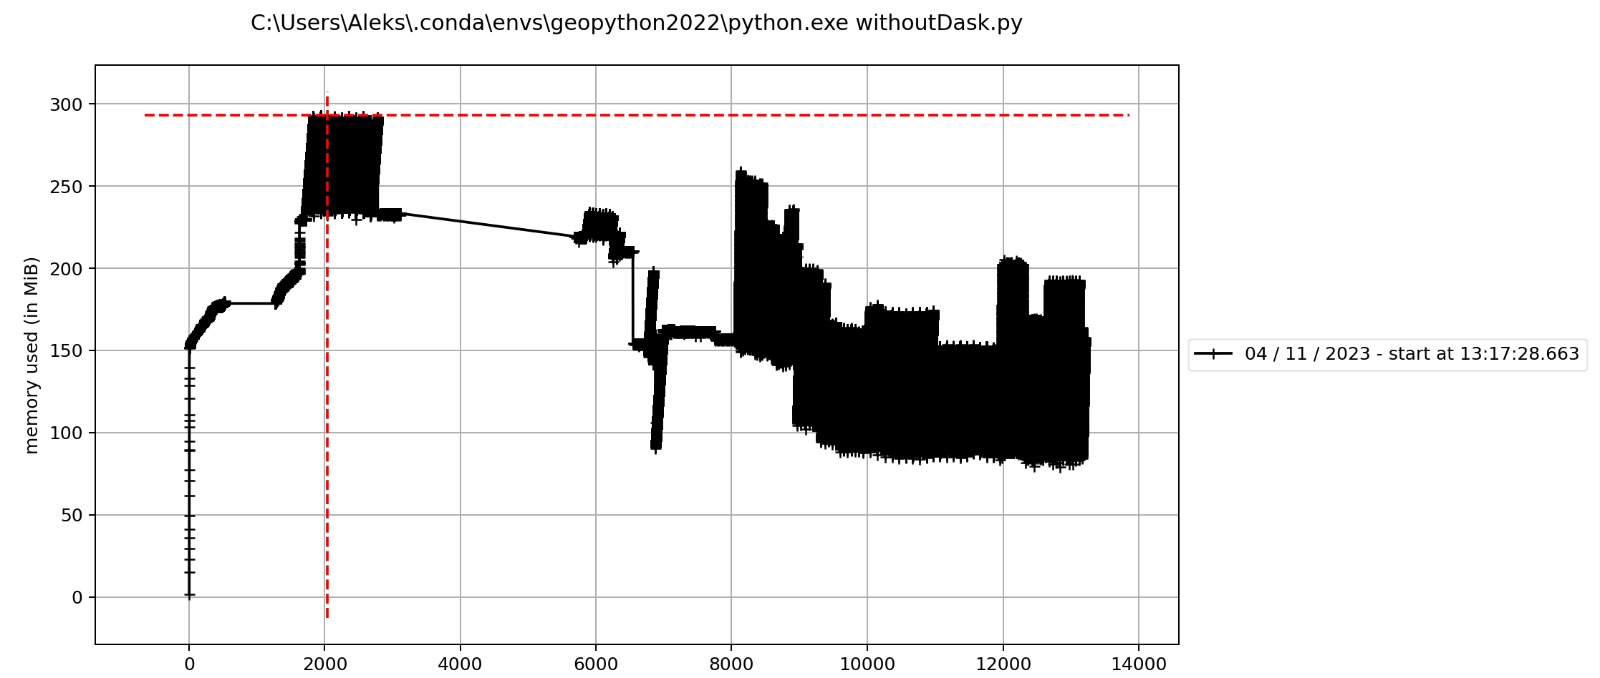

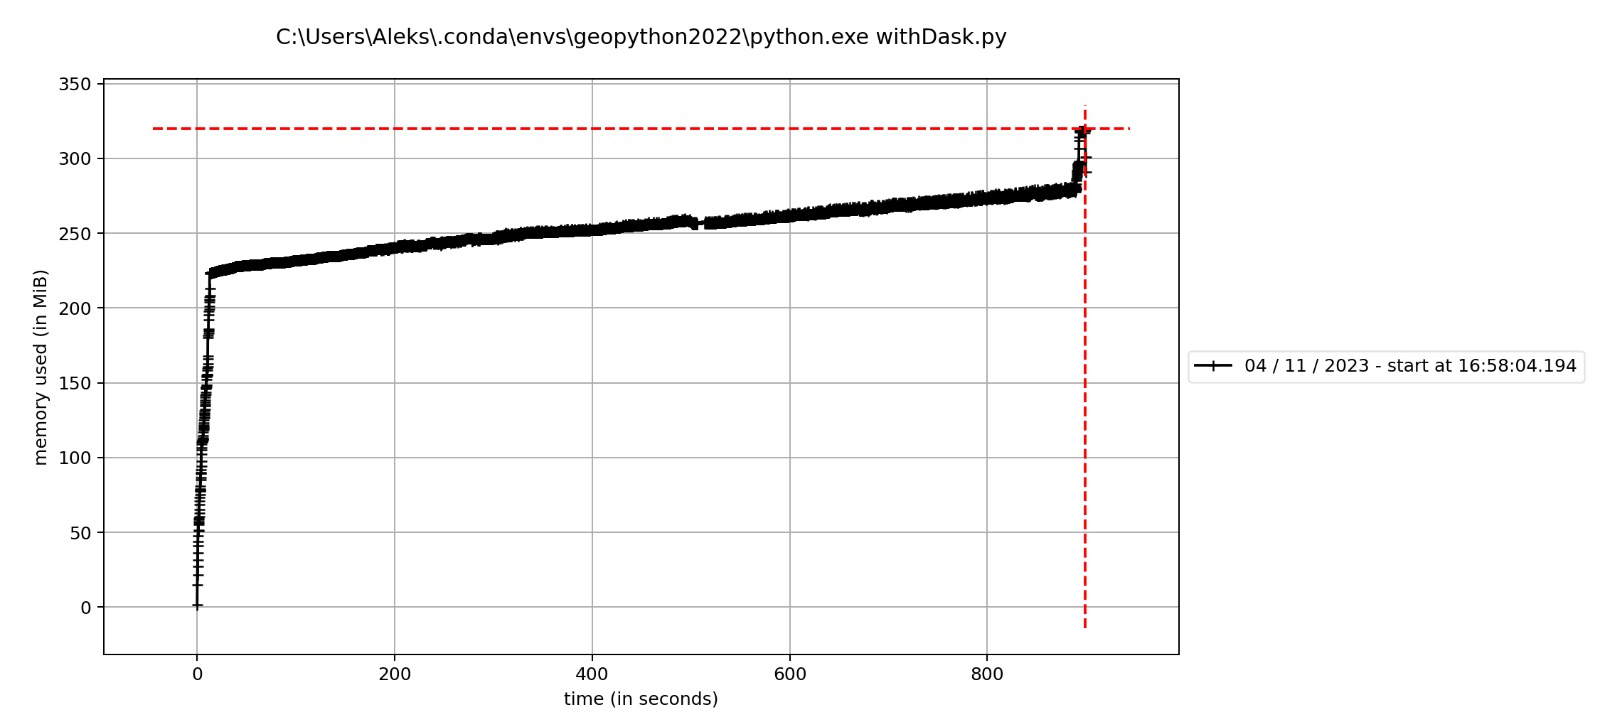




When we look at Dask preformance more closely we see additional interesting patterns. Below is a screen shot from the Dask dashboard profiler, when we changed the scheduler to be distributed.This task stream shows that there are no overlaps/communication between the tasks during creation of the model. The gaps or spaces however suggest there exists dead time between the tasks. One possible answer for this is that the tasks were too short and the workers were not kept busy long enough.

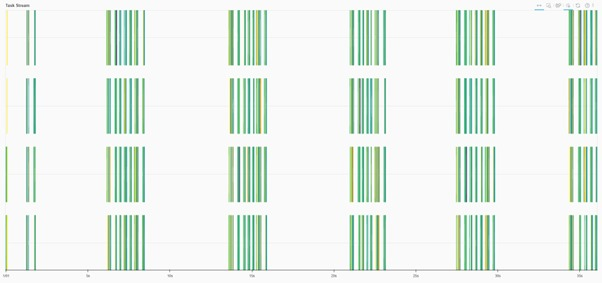

Our use of Dask in this assignement was limited. We primarly used it to figure out the hyper paramters and develope a better model. An additional task where Dask could be used, is reading in the data and making the main data frame. Additionally,as helpful as Dask can be, it is not the one tool fix for everything. For example hyperband search cv does not work with random forest classifer. This is why we used randomized search when looking for hyperparameters when comparing the Dask and non Dask version of this task. Also, our grid search took forever with or without Dask. 

## Usage of AI
Github Capilot was used in this assignment for suggestion about selection and usage of the packages, as well as tactics for bugs.